# Project 2: Word Embeddings and the Brain

## Semi-structured Tasks

In [5]:
!pip install spacy ftfy==4.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ftfy: filename=ftfy-4.4.3-py3-none-any.whl size=41076 sha256=024b22a15ed5fd8d95a27035e473bc6782a3f0359f842a589f61baaa49d19da1
  Stored in directory: /root/.cache/pip/wheels/ff/17/af/513573c0a8a561878536d1cd7d8c0c355095f5ac7d0c335305
Successfully built ftfy


In [6]:
!pip install -U spacy
!python -m spacy download en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.3
    Uninstalling spacy-3.5.3:
      Successfully uninstalled spacy-3.5.3
2023-07-05 07:20:46.719436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 07:20:48.473401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from learn_decoder import *
import pickle
from collections import defaultdict
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel, GPT2Tokenizer, GPT2Model
import torch
from sklearn.decomposition import PCA
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import scipy.stats
import seaborn as sns


### Part 1

We decided to train a decoder model on the dataset from analysis 2 (384 sentences).

According to Refael's advice in the reception hour, we used different models for additional training. We chose OpenAI-GPT models - GPT1 and GPT2 out of personal interest.

In [8]:
file_path = '/content/Structured Task (sentence decoding)/EXP2.pkl'  # Path to the EXP2 file
with open(file_path, 'rb') as exp2:
    exp2_dict = pickle.load(exp2)


In [9]:
# Load Fmridata from exp2_dict
exp2_data = exp2_dict.get("Fmridata")

# Read vectors from file
exp2_vectors_file = "vectors_384sentences.GV42B300.average.txt"
exp2_vectors = read_matrix("/content/Structured Task (sentence decoding)/vectors_384sentences.GV42B300.average.txt", sep=" ")

# Read sentences from file
exp2_sentences_file = "/content/Structured Task (sentence decoding)/stimuli_384sentences.txt"
with open(exp2_sentences_file, "r") as exp2_sentences:
    exp2_concepts = np.asarray(exp2_sentences.readlines())


In [10]:
# Calculate cosine similarity
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    similarity = dot_product / (norm_x * norm_y)
    return similarity


# Calculate the rank of a vector
def calculate_rank(index, target_vec, vectors):
  vectors_dict = defaultdict(None)
  for row in range(vectors.shape[0]):
    vectors_dict[row] = cosine_similarity(target_vec, vectors[row, :])
  vectors_dict = {k: v for k, v in sorted(vectors_dict.items(), key=lambda item: item[1], reverse=True)}
  for rank, key in enumerate(vectors_dict.keys(), start=1):
      if key == index:
          return rank

In [11]:
# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(exp2_concepts) // k

# Splitting the data into training and test sets according to 18-fold cross-validation
exp2_average_ranks = []
start = 0
end = concepts_per_fold
for i in range(k):
    test_vectors = exp2_vectors[start:end]
    test_data = exp2_data[start:end]
    test_list = list(range(start, end))
    train_list = list(set(range(len(exp2_data))) - set(test_list))

    # Train the decoder using the provided code
    decoder2 = learn_decoder(exp2_data[train_list, :], exp2_vectors[train_list, :])

    start += concepts_per_fold
    end += concepts_per_fold

    # Use the decoder to decode semantic vectors
    prediction2 = np.dot(test_data, decoder2)

    # Evaluate the accuracy of these decoded vectors
    ranks = []
    for v, index in enumerate(test_list):
        ranks.append(calculate_rank(index, prediction2[v], exp2_vectors))

    exp2_average_ranks.append(np.mean(ranks))

#### GPT-1 Model

In [12]:
# Mean Pooling from 'huggingface' - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [13]:
exp2_sentences = [sentence[0][0] for sentence in exp2_dict['keySentences']]

In [14]:
# Load the OpenAIGPTModel and tokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTModel.from_pretrained('openai-gpt')

In [15]:
# Tokenize sentences
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(exp2_sentences, padding=True, truncation=True, return_tensors='pt')
model.resize_token_embeddings(len(tokenizer))

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
sentence_embeddings_arr = np.array(sentence_embeddings)
pca = PCA(n_components=300)
exp2_vectors_gpt = pca.fit_transform(sentence_embeddings_arr)

In [16]:
# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(exp2_concepts) // k

# Splitting the data into training and test sets according to 18-fold cross-validation
exp2_average_ranks_gpt = []
start = 0
end = concepts_per_fold
for i in range(k):
    test_vectors = exp2_vectors_gpt[start:end]
    test_data = exp2_data[start:end]
    test_list = list(range(start, end))
    train_list = list(set(range(len(exp2_data))) - set(test_list))

    # Train the decoder using the provided code
    decoder2_gpt = learn_decoder(exp2_data[train_list, :], exp2_vectors_gpt[train_list, :])

    start += concepts_per_fold
    end += concepts_per_fold

    # Use the decoder to decode semantic vectors
    prediction2_gpt = np.dot(test_data, decoder2_gpt)

    # Evaluate the accuracy of these decoded vectors
    ranks = []
    for v, index in enumerate(test_list):
        ranks.append(calculate_rank(index, prediction2_gpt[v], exp2_vectors_gpt))

    exp2_average_ranks_gpt.append(np.mean(ranks))

mean:
70.354
std:
18.751


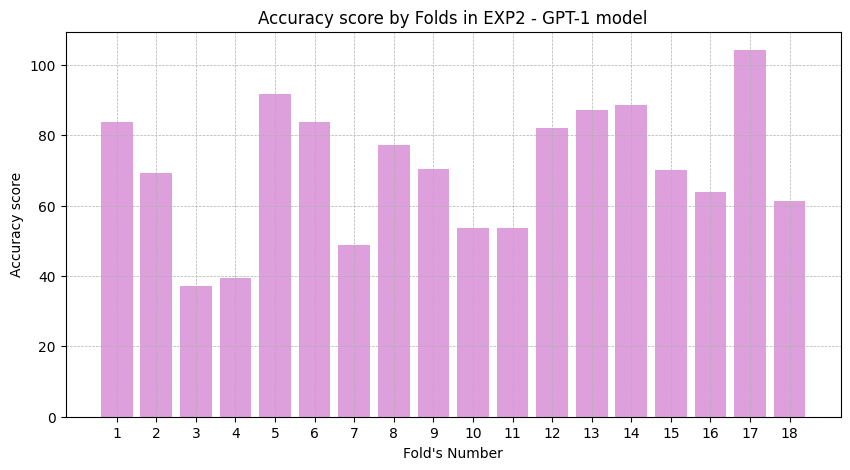

In [17]:
k = 18

x = np.arange(1, k+1)
y = exp2_average_ranks_gpt

print("mean:")
print(round(statistics.mean(y),3))
print("std:")
std = round(statistics.stdev(y),3)
print(std)
# Plotting the graph
plt.figure(figsize=(10,5))
plt.bar(x, y, color="plum")
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds in EXP2 - GPT-1 model')
plt.xticks(range(1, 19))
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.show()

#### GPT-2 Model

In [18]:
# Load the OpenAIGPTModel and tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

In [19]:
# Tokenize sentences
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(exp2_sentences, padding=True, truncation=True, return_tensors='pt')
model.resize_token_embeddings(len(tokenizer))

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
sentence_embeddings_arr = np.array(sentence_embeddings)
pca = PCA(n_components=300)
exp2_vectors_gpt2 = pca.fit_transform(sentence_embeddings_arr)


In [20]:
# Number of folds
k = 18

# Calculate the number of concepts per fold
concepts_per_fold = len(exp2_concepts) // k

# Splitting the data into training and test sets according to 18-fold cross-validation
exp2_average_ranks_gpt2 = []
start = 0
end = concepts_per_fold
for i in range(k):
    test_vectors = exp2_vectors_gpt2[start:end]
    test_data = exp2_data[start:end]
    test_list = list(range(start, end))
    train_list = list(set(range(len(exp2_data))) - set(test_list))

    # Train the decoder using the provided code
    decoder2_gpt2 = learn_decoder(exp2_data[train_list, :], exp2_vectors_gpt2[train_list, :])

    start += concepts_per_fold
    end += concepts_per_fold

    # Use the decoder to decode semantic vectors
    prediction2_gpt2 = np.dot(test_data, decoder2_gpt2)

    # Evaluate the accuracy of these decoded vectors
    ranks = []
    for v, index in enumerate(test_list):
        ranks.append(calculate_rank(index, prediction2_gpt2[v], exp2_vectors_gpt2))

    exp2_average_ranks_gpt2.append(np.mean(ranks))

mean:
155.159
std:
17.716


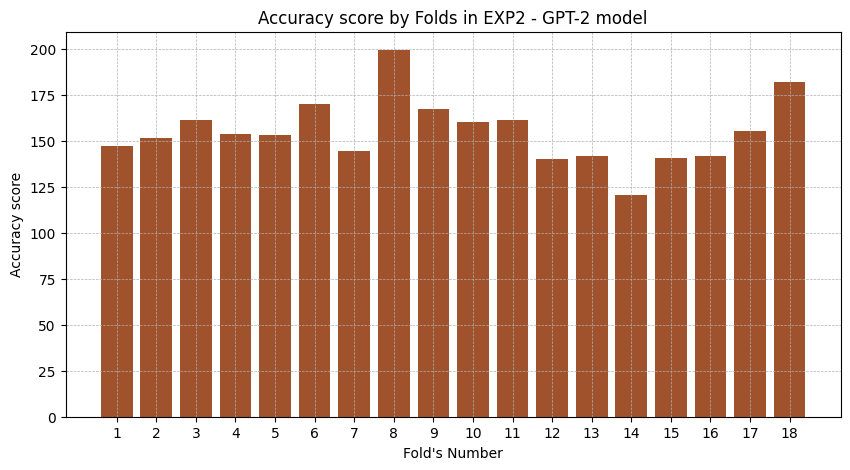

In [21]:
k = 18

x = np.arange(1, k+1)
y = exp2_average_ranks_gpt2

print("mean:")
print(round(statistics.mean(y),3))
print("std:")
std = round(statistics.stdev(y),3)
print(std)
# Plotting the graph
plt.figure(figsize=(10,5))
plt.bar(x, y, color="sienna")
plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Accuracy score by Folds in EXP2 - GPT-2 model')
plt.xticks(range(1, 19))
plt.grid(True, linestyle='dashed', linewidth = 0.5)
plt.show()

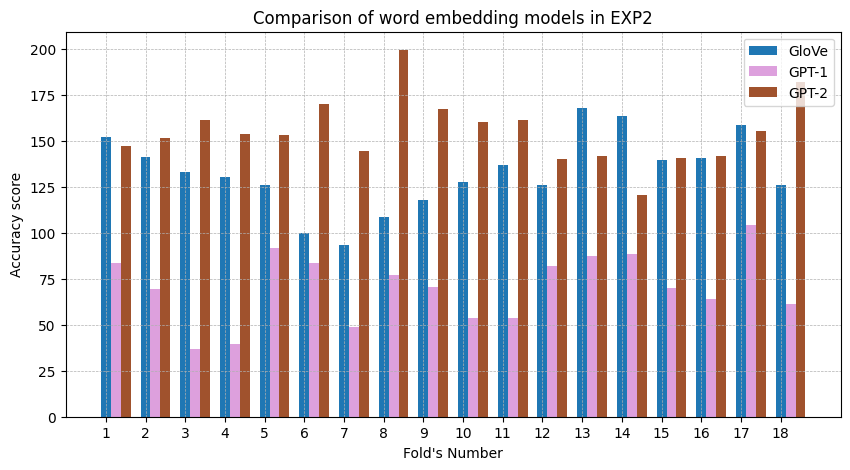

In [22]:
# Data for the bar graphs
k = 18
x = np.arange(1, k+1)

# Set the width of each bar
bar_width = 0.25

# Plotting the bar graphs
plt.figure(figsize=(10, 5))
plt.bar(x, exp2_average_ranks, label='GloVe', width=bar_width)
plt.bar(x + bar_width, exp2_average_ranks_gpt, color='plum', label='GPT-1', width=bar_width)
plt.bar(x + 2 * bar_width, exp2_average_ranks_gpt2, color='sienna', label='GPT-2', width=bar_width)

plt.xlabel("Fold's Number")
plt.ylabel('Accuracy score')
plt.title('Comparison of word embedding models in EXP2')
plt.xticks(range(1, k + 1))
plt.grid(True, linestyle='dashed', linewidth=0.5)
plt.legend(loc='upper right')

# Adjusting subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the combined plot
plt.show()


In [23]:
print("mean:")
print(f'GloVe Model: {round(statistics.mean(exp2_average_ranks),3)}')
print(f'GPT-1 Model: {round(statistics.mean(exp2_average_ranks_gpt),3)}')
print(f'GPT-2 Model: {round(statistics.mean(exp2_average_ranks_gpt2),3)}')
print()
print("std:")
print(f'GloVe Model: {round(statistics.stdev(exp2_average_ranks),3)}')
print(f'GPT-1 Model: {round(statistics.stdev(exp2_average_ranks_gpt),3)}')
print(f'GPT-2 Model: {round(statistics.stdev(exp2_average_ranks_gpt2),3)}')

mean:
GloVe Model: 132.775
GPT-1 Model: 70.354
GPT-2 Model: 155.159

std:
GloVe Model: 20.298
GPT-1 Model: 18.751
GPT-2 Model: 17.716


We can observe that the sentence representation model used in the paper (GloVe model) outperforms GPT-1 but is surpassed by GPT-2.

Furthermore, it is evident that GPT-2 significantly outperforms GPT-1, as reflected in its higher accuracy scores. The mean accuracy score of GPT-2 surpasses that of GPT-1, with a value of 155.156 compared to 70.394. In addition, GPT-2 exhibits lower standard deviation in its results compared to GPT-1, with values of 17.721 and 18.752, respectively.

Kudos to OpenAI.

### Part 2

In [24]:
def analyze_voxel_predictions(vectors):
    r2_scores = []
    p_values = []
    voxels_num = exp2_data.shape[1]
    counter_significant_voxels = 0

    # Iterate over voxels
    for voxel in range(0, voxels_num, 1000):
        # Extract voxel data for the current voxel index
        curr_voxel_data = exp2_data[:, voxel]

        # Fit a linear regression model using the input vectors and voxel data
        linearRegression = LinearRegression()
        model = linearRegression.fit(vectors, curr_voxel_data)

        # Make predictions using the trained model
        predictions = model.predict(vectors)

        # Calculate the R^2 score between the voxel data and predictions
        r2 = sklearn.metrics.r2_score(curr_voxel_data, predictions)
        r2_scores.append(r2)

        # Calculate the paired t-test between the predictions and voxel data
        t_statistic, p_value = scipy.stats.ttest_rel(model.predict(vectors), curr_voxel_data)
        p_values.append(p_value)  # Append the p-value to the list

        alpha = 0.05  # Significance level
        if p_value < alpha and r2 > 0.1:
            counter_significant_voxels += 1

    return counter_significant_voxels, r2_scores, p_values


In [25]:
# Glove

r2_scores_ex2_glove = []
p_values_ex2_glove = []
significant_voxels_ex2_glove = 0
voxels_num = exp2_data.shape[1]

# Iterate over voxels
for voxel in range(0, voxels_num, 1000):
  # Extract voxel data for the current voxel index
  curr_voxel_data = exp2_data[:, voxel]

  # Fit a linear regression model using the input vectors and voxel data
  linearRegression = LinearRegression()
  model = linearRegression.fit(exp2_vectors, curr_voxel_data)

  # Make predictions using the trained model
  predictions = model.predict(exp2_vectors)

  # Calculate the R^2 score between the voxel data and predictions
  r2 = sklearn.metrics.r2_score(curr_voxel_data, predictions)
  r2_scores_ex2_glove.append(r2)

  # Calculate the paired t-test between the predictions and voxel data
  t_statistic, p_value = scipy.stats.ttest_rel(model.predict(exp2_vectors), curr_voxel_data)
  p_values_ex2_glove.append(p_value)  # Append the p-value to the list

  alpha = 0.05  # Significance level
  if p_value < alpha and r2 > 0.1:
      significant_voxels_ex2_glove += 1


In [26]:
# GPT-1

r2_scores_ex2_gpt = []
p_values_ex2_gpt = []
significant_voxels_ex2_gpt = 0
voxels_num = exp2_data.shape[1]

# Iterate over voxels
for voxel in range(0, voxels_num, 1000):
  # Extract voxel data for the current voxel index
  curr_voxel_data = exp2_data[:, voxel]

  # Fit a linear regression model using the input vectors and voxel data
  linearRegression = LinearRegression()
  model = linearRegression.fit(exp2_vectors_gpt, curr_voxel_data)

  # Make predictions using the trained model
  predictions = model.predict(exp2_vectors_gpt)

  # Calculate the R^2 score between the voxel data and predictions
  r2 = sklearn.metrics.r2_score(curr_voxel_data, predictions)
  r2_scores_ex2_gpt.append(r2)

  # Calculate the paired t-test between the predictions and voxel data
  t_statistic, p_value = scipy.stats.ttest_rel(model.predict(exp2_vectors_gpt), curr_voxel_data)
  p_values_ex2_gpt.append(p_value)  # Append the p-value to the list

  alpha = 0.05  # Significance level
  if p_value < alpha and r2 > 0.1:
      significant_voxels_ex2_gpt += 1

In [27]:
# GPT-2

r2_scores_ex2_gpt2 = []
p_values_ex2_gpt2 = []
significant_voxels_ex2_gpt2 = 0
voxels_num = exp2_data.shape[1]

# Iterate over voxels
for voxel in range(0, voxels_num, 1000):
  # Extract voxel data for the current voxel index
  curr_voxel_data = exp2_data[:, voxel]

  # Fit a linear regression model using the input vectors and voxel data
  linearRegression = LinearRegression()
  model = linearRegression.fit(exp2_vectors_gpt2, curr_voxel_data)

  # Make predictions using the trained model
  predictions = model.predict(exp2_vectors_gpt2)

  # Calculate the R^2 score between the voxel data and predictions
  r2 = sklearn.metrics.r2_score(curr_voxel_data, predictions)
  r2_scores_ex2_gpt2.append(r2)

  # Calculate the paired t-test between the predictions and voxel data
  t_statistic, p_value = scipy.stats.ttest_rel(model.predict(exp2_vectors_gpt2), curr_voxel_data)
  p_values_ex2_gpt2.append(p_value)  # Append the p-value to the list

  alpha = 0.05  # Significance level
  if p_value < alpha and r2 > 0.1:
      significant_voxels_ex2_gpt2 += 1

For each voxel/model, let's calculate the mean R^2 score and examine how many voxels are significantly associated with the information embedded in the word vectors.


In [28]:
r2_means_arr = [np.mean(r2_scores_ex2_glove), np.mean(r2_scores_ex2_gpt), np.mean(r2_scores_ex2_gpt2)]
r2_scores_arr = r2_scores_ex2_glove + r2_scores_ex2_gpt + r2_scores_ex2_gpt2
labels_arr = ['GloVe', 'GPT-1', 'GPT-2']
group_labels = ['GloVe'] * len(r2_scores_ex2_glove) + ['GPT-1'] * len(r2_scores_ex2_gpt) + ['GPT-2'] * len(r2_scores_ex2_gpt2)

In [29]:
print("Mean R^2 scores:")
print(f'GloVe Model: {round(r2_means_arr[0],3)}')
print(f'GPT-1 Model: {round(r2_means_arr[1],3)}')
print(f'GPT-2 Model: {round(r2_means_arr[2],3)}')
print()
print("Number of significantly associated voxels:")
print(f'GloVe Model: {significant_voxels_ex2_glove}')
print(f'GPT-1 Model: {significant_voxels_ex2_gpt}')
print(f'GPT-2 Model: {significant_voxels_ex2_gpt2}')

Mean R^2 scores:
GloVe Model: 0.802
GPT-1 Model: 0.813
GPT-2 Model: 0.813

Number of significantly associated voxels:
GloVe Model: 0
GPT-1 Model: 0
GPT-2 Model: 0


Let's examine how well those voxels were predicted

In [30]:
# Convert p-values lists to numpy arrays
p_values_ex2_glove = np.array(p_values_ex2_glove)
p_values_ex2_gpt = np.array(p_values_ex2_gpt)
p_values_ex2_gpt2 = np.array(p_values_ex2_gpt2)

# Number of significantly associated voxels
num_significant_glove = np.sum(p_values_ex2_glove < 0.05)
num_significant_gpt = np.sum(p_values_ex2_gpt < 0.05)
num_significant_gpt2 = np.sum(p_values_ex2_gpt2 < 0.05)

significantly_voxels_arr = [num_significant_glove, num_significant_gpt, num_significant_gpt2]

Text(0, 0.5, 'Number of voxels')

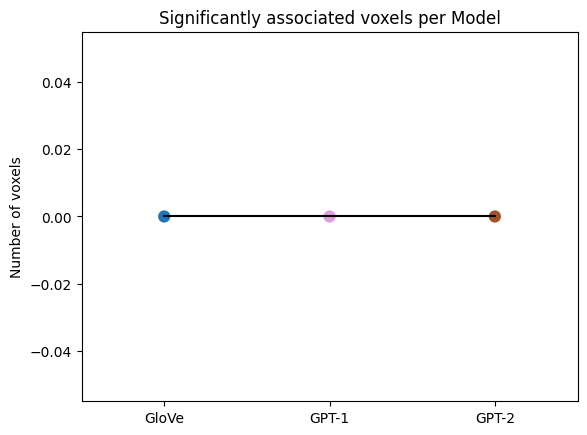

In [38]:
# Comparision of the significantly associated voxels per model

fig, axes = plt.subplots(1, 1)

palette = ['tab:blue', 'plum', 'sienna']
sns.lineplot(x=labels_arr, y=significantly_voxels_arr, color='black')
sns.pointplot(x=labels_arr, y=significantly_voxels_arr, palette=palette)

axes.set_title('Significantly associated voxels per Model')
axes.set_ylabel('Number of voxels')


We will take a look to the R^2 scores and the P-Values such as we did in tutorial 3 about "Statistical inference":

Text(0, 0.5, 'Mean R^2 Score')

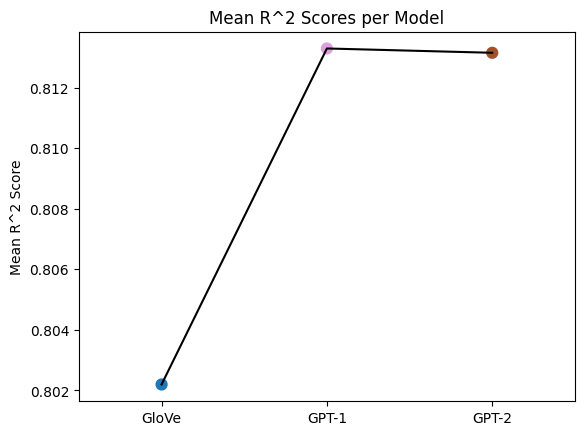

In [32]:
# Comparison of the Mean R^2 Scores per model

fig, axes = plt.subplots(1, 1)

palette = ['tab:blue', 'plum', 'sienna']
sns.lineplot(x=labels_arr, y=r2_means_arr, color='black')
sns.pointplot(x=labels_arr, y=r2_means_arr, palette=palette)

axes.set_title('Mean R^2 Scores per Model')
axes.set_ylabel('Mean R^2 Score')


<ipython-input-33-0fbdce96d8fe>:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=r2_scores_arr, y=group_labels, jitter=True, palette=palette, linewidth=1,edgecolor='gray', alpha=0.5 , orient='h')


Text(0.5, 0, 'R^2 score')

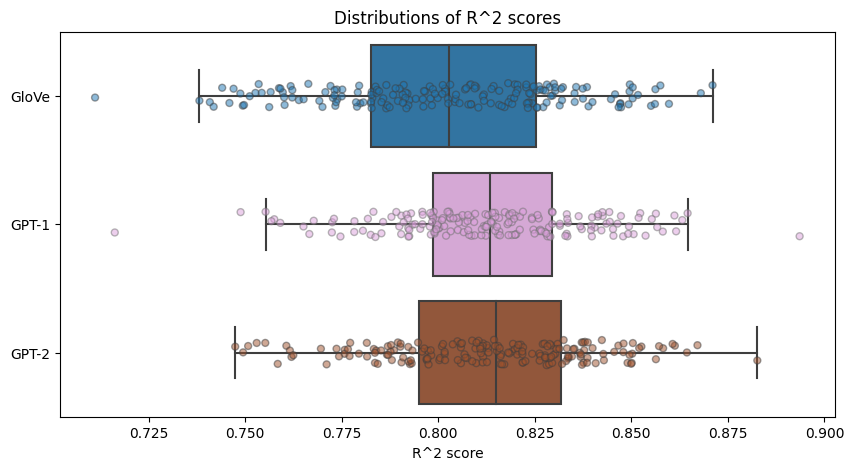

In [33]:
# Comparing the Distributions of R^2 Scores per Model

_, axes = plt.subplots(1, 1, figsize=(10, 5))

palette = ['tab:blue', 'plum', 'sienna']

sns.stripplot(x=r2_scores_arr, y=group_labels, jitter=True, palette=palette, linewidth=1,edgecolor='gray', alpha=0.5 , orient='h')
sns.boxplot(x=r2_scores_arr, y=group_labels, palette=palette,fliersize=0 , orient='h')

axes.set_title('Distributions of R^2 scores')
axes.set_xlabel('R^2 score')


Now, we will calculate confidence intervals for the mean R^2 in each model with confidence level of 0.9:

In [34]:
r2_scores_ex2_glove_mean_CI = scipy.stats.bootstrap((r2_scores_ex2_glove,), np.mean, confidence_level=0.9).confidence_interval
r2_scores_ex2_gpt_mean_CI = scipy.stats.bootstrap((r2_scores_ex2_gpt,), np.mean, confidence_level=0.9).confidence_interval
r2_scores_ex2_gpt2_mean_CI = scipy.stats.bootstrap((r2_scores_ex2_gpt2,), np.mean, confidence_level=0.9).confidence_interval

print('Confidence Intervals for the mean R^2: ')
print(f'GloVe: {r2_scores_ex2_glove_mean_CI}')
print(f'GPT-1: {r2_scores_ex2_gpt_mean_CI}')
print(f'GPT-2: {r2_scores_ex2_gpt2_mean_CI}')

Confidence Intervals for the mean R^2: 
GloVe: ConfidenceInterval(low=0.7983735710722256, high=0.8058356144969091)
GPT-1: ConfidenceInterval(low=0.8101787002379147, high=0.8162488888173407)
GPT-2: ConfidenceInterval(low=0.8098750320143159, high=0.8162793182319829)


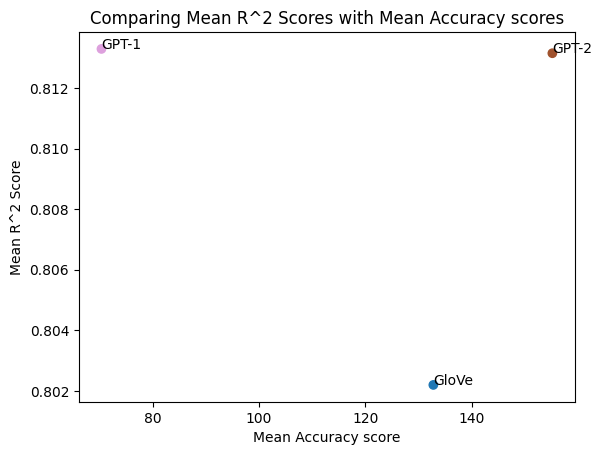

In [35]:
# Comparison of the Mean R^2 Scores and the Mean accuracy score per Model

mean_ranks_arr = [statistics.mean(exp2_average_ranks), statistics.mean(exp2_average_ranks_gpt), statistics.mean(exp2_average_ranks_gpt2)]

colors = ['tab:blue', 'plum', 'sienna']

plt.scatter(mean_ranks_arr, r2_means_arr, c=colors)
plt.xlabel('Mean Accuracy score')
plt.ylabel('Mean R^2 Score')

plt.title('Comparing Mean R^2 Scores with Mean Accuracy scores')
for i, label in enumerate(labels_arr):
    plt.annotate(label, (mean_ranks_arr[i], r2_means_arr[i]))



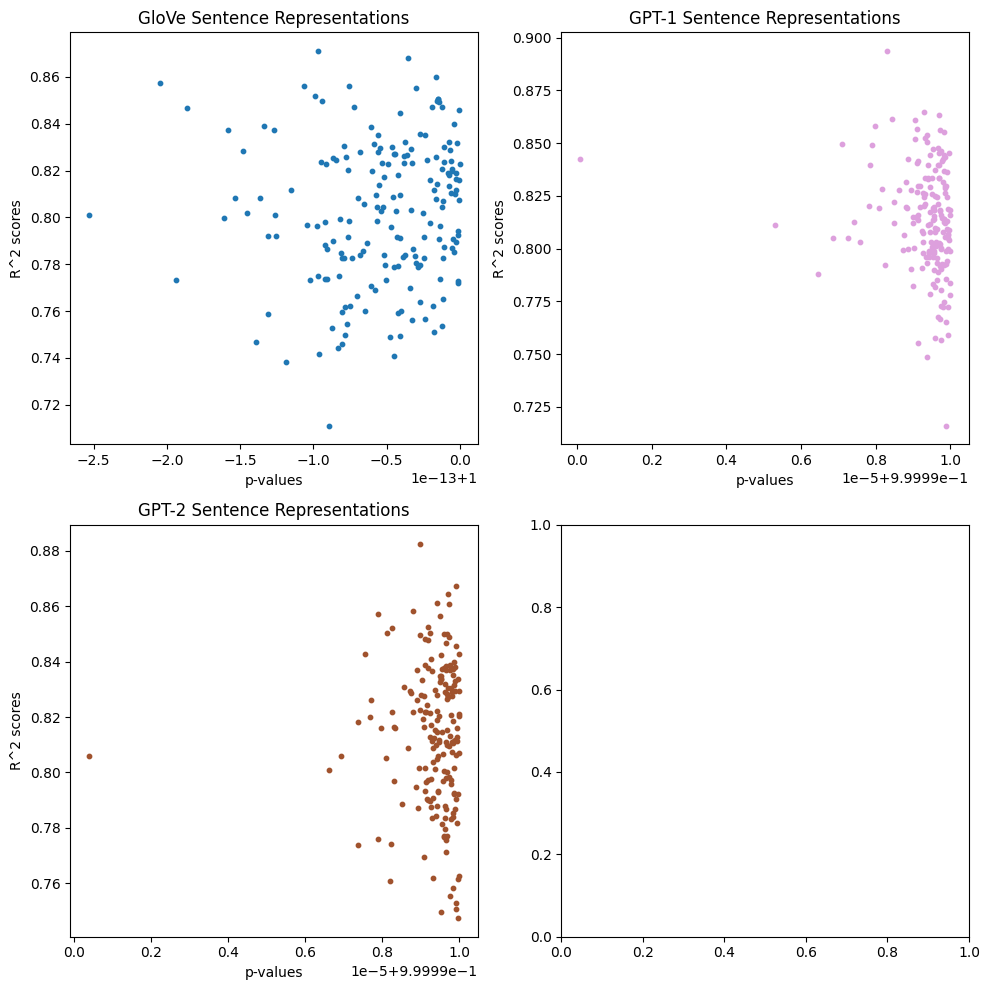

In [36]:
# Comparison of the R^2 Scores and the p-value scores per Model

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot for GloVe representations
axes[0, 0].scatter(p_values_ex2_glove, r2_scores_ex2_glove, s=10, color=colors[0])
axes[0, 0].set_xlabel('p-values')
axes[0, 0].set_ylabel('R^2 scores')
axes[0, 0].set_title('GloVe Sentence Representations')

# Plot for GPT-1 sentence representations
axes[0, 1].scatter(p_values_ex2_gpt, r2_scores_ex2_gpt, s=10, color=colors[1])
axes[0, 1].set_xlabel('p-values')
axes[0, 1].set_ylabel('R^2 scores')
axes[0, 1].set_title('GPT-1 Sentence Representations')

# Plot for GPT-2 sentence representations
axes[1, 0].scatter(p_values_ex2_gpt2, r2_scores_ex2_gpt2, s=10, color=colors[2])
axes[1, 0].set_xlabel('p-values')
axes[1, 0].set_ylabel('R^2 scores')
axes[1, 0].set_title('GPT-2 Sentence Representations')

# Additional plots can be added as needed

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [37]:
p_values_ex2_glove_mean_CI = scipy.stats.bootstrap((p_values_ex2_glove,), np.mean, confidence_level=0.9).confidence_interval
p_values_ex2_gpt_mean_CI = scipy.stats.bootstrap((p_values_ex2_gpt,), np.mean, confidence_level=0.9).confidence_interval
p_values_ex2_gpt2_mean_CI = scipy.stats.bootstrap((p_values_ex2_gpt2,), np.mean, confidence_level=0.9).confidence_interval

print('Confidence Intervals for the mean P-Value: ')
print(f'GloVe: {p_values_ex2_glove_mean_CI}')
print(f'GPT-1: {p_values_ex2_gpt_mean_CI}')
print(f'GPT-2: {p_values_ex2_gpt2_mean_CI}')

Confidence Intervals for the mean P-Value: 
GloVe: ConfidenceInterval(low=0.9999999999999394, high=0.9999999999999504)
GPT-1: ConfidenceInterval(low=0.9999991504442773, high=0.999999400564874)
GPT-2: ConfidenceInterval(low=0.9999991421180766, high=0.9999993792018596)
